# Notebook for the training of the models

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.measure
from datetime import datetime

import random
import copy
import math
import cv2
import os

2024-02-01 22:56:01.315981: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 22:56:01.345820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 22:56:01.345844: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 22:56:01.345862: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 22:56:01.351908: I tensorflow/core/platform/cpu_feature_g

In [3]:
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Thu Feb  1 22:56:03 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    On   | 00000000:1A:00.0 Off |                  Off |
| 30%   32C    P8    18W / 230W |  23427MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+--

# Variables definition

In [4]:
div = 32
step = int(32/4)

sem_dict = ['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree','restricted','grass','intersection']
chans = len(sem_dict)+1

lut_in = [0, 20, 50, 100, 150, 255]
lut_out = [0, 100, 180, 220, 240, 255]
lut_8u = np.interp(np.arange(0, 256), lut_in, lut_out).astype(np.uint8)

spec = 'stan'
train_data_dir = 'training_data_'+spec

now = datetime.now() # current date and time
date = now.strftime("%d")+now.strftime("%b").lower()
print(date)

filename = 'IRI_models/'+date+'_'+str(step)+'px_steps_'+spec+'_paths'
filename1 = 'IRI_models/'+date+'_'+str(step)+'px_steps_'+spec+'_vels'
filename2 = 'IRI_models/'+date+'_'+str(step)+'px_steps_'+spec+'_stops'

01feb


# Loading training data

In [5]:
train_x = np.loadtxt(train_data_dir+'/train_X.csv')
sizes = train_x[0:4].astype(int)
train_x = np.delete(train_x, [0,1,2,3])
train_x = np.reshape(train_x,sizes)

train_y = np.loadtxt(train_data_dir+'/train_Y.csv')
sizes = train_y[0:3].astype(int)
train_y = np.delete(train_y, [0,1,2])
train_y = np.reshape(train_y,sizes)

# train_y1 = np.loadtxt(train_data_dir+'/train_Y1.csv')
# sizes = train_y1[0:3].astype(int)
# train_y1 = np.delete(train_y1, [0,1,2])
# train_y1 = np.reshape(train_y1,sizes)

# train_y2 = np.loadtxt(train_data_dir+'/train_Y2.csv')
# sizes = train_y2[0:3].astype(int)
# train_y2 = np.delete(train_y2, [0,1,2])
# train_y2 = np.reshape(train_y2,sizes)

print(train_x.shape)
# print(train_y.shape)
# print(train_y1.shape)
# print(train_y2.shape)

test_x = np.loadtxt(train_data_dir+'/test_X.csv')
sizes = test_x[0:4].astype(int)
test_x = np.delete(test_x, [0,1,2,3])
test_x = np.reshape(test_x,sizes)

test_y = np.loadtxt(train_data_dir+'/test_Y.csv')
sizes = test_y[0:3].astype(int)
test_y = np.delete(test_y, [0,1,2])
test_y = np.reshape(test_y,sizes)

# test_y1 = np.loadtxt(train_data_dir+'/test_Y1.csv')
# sizes = test_y1[0:3].astype(int)
# test_y1 = np.delete(test_y1, [0,1,2])
# test_y1 = np.reshape(test_y1,sizes)

# test_y2 = np.loadtxt(train_data_dir+'/test_Y2.csv')
# sizes = test_y2[0:3].astype(int)
# test_y2 = np.delete(test_y2, [0,1,2])
# test_y2 = np.reshape(test_y2,sizes)

print(test_x.shape)
# print(test_y.shape)
# print(test_y1.shape)
# print(test_y2.shape)

(9750, 32, 32, 11)
(9750, 32, 32, 11)


# Models definition

In [6]:
# CNN-11  |  CNN-21  |  CNN-31
fil_array = [4,8,8]                         #Num filters first conv: 4, 8 or 8
lay_array = [1,3,5]                         #Layers per dense block: 1, 3 or 5
learn_array = [8.71e-5,3.72e-4,1.51e-4]     #Learning rates
decaylearn_array = [0.9984,0.9984,0.9985]   #Learning rate decays
wdecay_array = [1.11e-6,5.53e-7,4.58e-5]    #Weight decays
dropout_array = [0.307,0.120,0.349]         #Dropout probability

arc = 2                                     #[0,1,2]

filters = fil_array[arc]
layers_in_dense = lay_array[arc]

tf.random.set_seed(0)
dropout_array[arc] = dropout_array[arc] * 0.01

def dense_factor(inputs):
    h_1 = layers.BatchNormalization()(inputs)
    output = layers.Conv2D(32, (3,3), padding='same', activation='relu')(h_1)
    return output

def dense_block(inputs, upsampling):
    concatenated_inputs = inputs
    concatenated_inputs_less = []
    for i in range(layers_in_dense):
        x = dense_factor(concatenated_inputs)
        concatenated_inputs = layers.concatenate([concatenated_inputs, x], axis=3)
        concatenated_inputs_less = layers.concatenate([concatenated_inputs, x], axis=3)
        if(i == layers_in_dense - 1 and upsampling):
            concatenated_inputs = concatenated_inputs_less

    return concatenated_inputs

norm_layer = layers.Normalization(axis=None)
norm_layer.adapt(train_x)

input_img = layers.Input(shape=(div, div, chans))

augment_input = norm_layer(input_img)
augment_input = layers.RandomRotation(factor=0.5)(augment_input)
augment_input = layers.RandomFlip(mode='horizontal_and_vertical')(augment_input)
augment_input = layers.RandomZoom(height_factor=0.2, width_factor=0.2)(augment_input)

lays = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(augment_input)
lays = layers.Dropout(dropout_array[arc])(lays)
filters = filters+2
lays = dense_block(lays,False)
lays = layers.Dropout(dropout_array[arc])(lays)
layerX = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)
filters = filters+1
lays = layers.MaxPooling2D((2, 2), strides=2)(layerX)
lays = dense_block(lays,False)
lays = layers.Dropout(dropout_array[arc])(lays)
layerY = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)
lays = layers.MaxPooling2D((2, 2), strides=2)(layerY)

lays = dense_block(lays,True)

lays = layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)
lays = layers.Add()([layerY,lays])
lays = dense_block(lays,True)
lays = layers.Dropout(dropout_array[arc])(lays)
filters = filters-1
lays = layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)
lays = layers.Add()([layerX,lays])
lays = dense_block(lays,False)
lays = layers.Dropout(dropout_array[arc])(lays)
filters = filters-2
lays = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)
lays = layers.Dense(units=2, activation='softmax')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)

model = models.Model(input_img, lays)

model1 = tf.keras.models.clone_model(model)
model2 = tf.keras.models.clone_model(model)

# model.summary()

2024-02-01 22:56:21.358337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22193 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-02-01 22:56:21.358870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22315 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:68:00.0, compute capability: 8.6
2024-02-01 22:56:22.420505: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [7]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=learn_array[arc],
                    decay_steps=10,
                    decay_rate=decaylearn_array[arc])

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule,weight_decay=wdecay_array[arc])
lr_metric = get_lr_metric(opt)

model.compile(
    optimizer=opt,
    # Loss function to minimize
    loss='binary_crossentropy',
    # List of metrics to monitor
    metrics=['mean_squared_error'],
) 

model1.compile(
    optimizer=opt,
    # Loss function to minimize
    loss='binary_crossentropy',
    # List of metrics to monitor
    metrics=['mean_squared_error'],
) 

model2.compile(
    optimizer=opt,
    # Loss function to minimize
    loss='binary_crossentropy',
    # List of metrics to monitor
    metrics=['mean_squared_error'],
) 

# Training of model 1

In [8]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15),
    # tf.keras.callbacks.ModelCheckpoint(filepath='IRI_models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = model.fit(
    x=train_x,
    y=np.stack((train_y,1-train_y),axis=3),
    batch_size=600,
    epochs=100, #100
    validation_data=(test_x, np.stack((test_y,1-test_y),axis=3)),
    callbacks=my_callbacks,
)

# history = model.fit(
#     x=train_x,
#     y=train_y,
#     batch_size=50,
#     epochs=100, #100
#     validation_data=(test_x, test_y),
#     callbacks=my_callbacks,
# )

# if not os.path.exists(filename):
model.save(filename)

Epoch 1/100


2024-02-01 22:56:30.198180: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-01 22:56:32.722426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-01 22:56:33.302628: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-01 22:56:34.749137: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4b44268710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-01 22:56:34.749158: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-02-01 22:56:34.749162: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capabi

17/17 [==============================] - 31s 560ms/step - loss: 0.4263 - mean_squared_error: 0.0671 - val_loss: 0.5714 - val_mean_squared_error: 0.1343
Epoch 2/100
17/17 [==============================] - 5s 278ms/step - loss: 0.2881 - mean_squared_error: 0.0145 - val_loss: 0.4729 - val_mean_squared_error: 0.0881
Epoch 3/100
17/17 [==============================] - 5s 279ms/step - loss: 0.2768 - mean_squared_error: 0.0127 - val_loss: 0.4035 - val_mean_squared_error: 0.0585
Epoch 4/100
17/17 [==============================] - 5s 280ms/step - loss: 0.2728 - mean_squared_error: 0.0120 - val_loss: 0.3562 - val_mean_squared_error: 0.0405
Epoch 5/100
17/17 [==============================] - 5s 280ms/step - loss: 0.2703 - mean_squared_error: 0.0116 - val_loss: 0.3202 - val_mean_squared_error: 0.0283
Epoch 6/100
17/17 [==============================] - 5s 280ms/step - loss: 0.2685 - mean_squared_error: 0.0113 - val_loss: 0.2938 - val_mean_squared_error: 0.0206
Epoch 7/100
17/17 [==============

INFO:tensorflow:Assets written to: IRI_models/01feb_8px_steps_stan_paths/assets


In [9]:
# aux_x = validation_x
# aux_y = validation_y

# output = model.predict(aux_x,verbose=0)[:,:,:,0]

# n = num_validation  # How many images we will display
# plt.figure(figsize=(25, 5))
# for i in range(n):
#     # Display original
#     ax = plt.subplot(2, n, i + 1)
#     plt.imshow(np.multiply(np.stack((aux_x[i,:,:,0],aux_x[i,:,:,0],aux_x[i,:,:,0]),axis=2), np.stack((np.full(aux_y[i].shape,1),1-aux_y[i],1-aux_y[i]),axis=2)))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     # Display reconstruction
#     ax = plt.subplot(2, n, i + 1 + n)
#     plt.imshow(np.multiply(np.stack((aux_x[i,:,:,0],aux_x[i,:,:,0],aux_x[i,:,:,0]),axis=2), np.stack((np.full(output[i].shape,1),1-output[i],1-output[i]),axis=2)))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# # Display original
# plt.show()

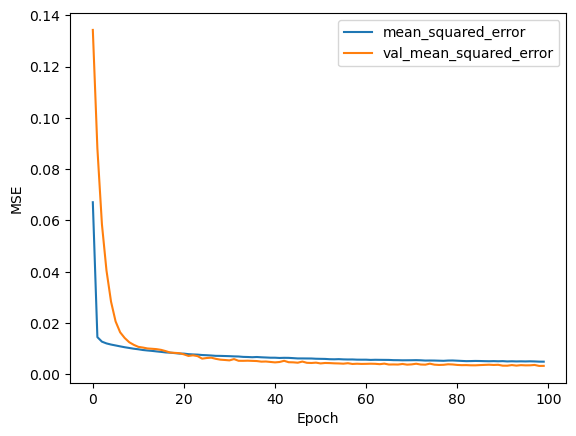

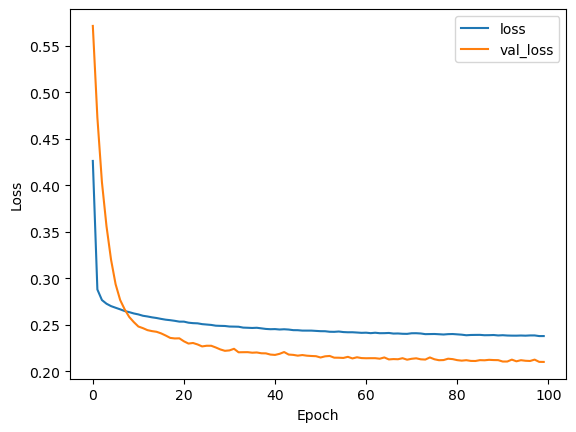

In [11]:
# test_loss, test_acc = model.evaluate(aux_x,  np.stack((val_y,1-val_y),axis=3), verbose=2)

plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')

plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# Training of model 2

In [ ]:
history = model1.fit(
    x=train_x,
    y=np.stack((train_y1,1-train_y1),axis=3),
    batch_size=50,
    epochs=100, #100
    validation_data=(test_x, np.stack((test_y1,1-test_y1),axis=3)),
    callbacks=my_callbacks,
)

if not os.path.exists(filename1):
    model1.save(filename1)

In [ ]:
# aux_x = validation_x
# aux_y = validation_y1

# output = model1.predict(aux_x,verbose=0)[:,:,:,0]

# n = num_validation  # How many images we will display
# plt.figure(figsize=(25, 5))
# for i in range(n):
#     # Display original
#     ax = plt.subplot(2, n, i + 1)
#     plt.imshow(np.multiply(np.stack((aux_x[i,:,:,0],aux_x[i,:,:,0],aux_x[i,:,:,0]),axis=2), np.stack((np.full(aux_y[i].shape,1),1-aux_y[i],1-aux_y[i]),axis=2)))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     # Display reconstruction
#     ax = plt.subplot(2, n, i + 1 + n)
#     plt.imshow(np.multiply(np.stack((aux_x[i,:,:,0],aux_x[i,:,:,0],aux_x[i,:,:,0]),axis=2), np.stack((np.full(output[i].shape,1),1-output[i],1-output[i]),axis=2)))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# # Display original
# plt.show()

In [ ]:
# test_loss, test_acc = model.evaluate(aux_x,  np.stack((validation_y1,1-validation_y1),axis=3), verbose=2)

plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')

plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# Training of model 3

In [ ]:
history = model2.fit(
    x=train_x,
    y=np.stack((train_y2,1-train_y2),axis=3),
    batch_size=50,
    epochs=100, #100
    validation_data=(test_x, np.stack((test_y2,1-test_y2),axis=3)),
    callbacks=my_callbacks,
)

if not os.path.exists(filename2):
    model2.save(filename2)

In [ ]:
# aux_x = validation_x
# aux_y = validation_y2

# output = model2.predict(aux_x,verbose=0)[:,:,:,0]

# n = num_validation  # How many images we will display
# plt.figure(figsize=(25, 5))
# for i in range(n):
#     # Display original
#     ax = plt.subplot(2, n, i + 1)
#     plt.imshow(np.multiply(np.stack((aux_x[i,:,:,0],aux_x[i,:,:,0],aux_x[i,:,:,0]),axis=2), np.stack((np.full(aux_y[i].shape,1),1-aux_y[i],1-aux_y[i]),axis=2)))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     # Display reconstruction
#     ax = plt.subplot(2, n, i + 1 + n)
#     plt.imshow(np.multiply(np.stack((aux_x[i,:,:,0],aux_x[i,:,:,0],aux_x[i,:,:,0]),axis=2), np.stack((np.full(output[i].shape,1),1-output[i],1-output[i]),axis=2)))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# # Display original
# plt.show()

In [ ]:
# test_loss, test_acc = model.evaluate(aux_x,  np.stack((validation_y2,1-validation_y2),axis=3), verbose=2)

plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')

plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# NOTES

- [x] Add benches, tables & chairs
- [x] Add also velocity information (two different maps for velocities and regions of stop)
- [x]    80% of time people pass stair and not sit
- [x]    white noise velocity 
- [ ] Add heading of motion (directional velocity)
- [ ] MAYBE Time of the day

- [ ] mobility: main cues they are looking for (narrow places, which other criterias?) "Criterium" what do we need to look for
(from computer vision)

- [ ] collect data with following robot/static robot

- Add the velocity and stop information is enough novelty?
- Could the same network handle everything (all outputs: occupancy, velocity, stops)? First try seems not.. (only with occupancy and velocity.. but it could be my fault! binary crossentropy!!!)
- Could same network handle both people, cars and bicycles?
- Paper "Learning Occupancy Priors of Human Motion From Semantic Maps of Urban Enviroments" uses KL-divergence to compare to baselines.
    They say that "only a few methods explicitly highlight the performance in new environments outside the training scenario"
    Their future work section: "Furthermore, we plan to validate semapp with on-the-fly semantics estimation and extend it to first-person view for application in automated driving to infer potential pedestrians’ entrance points to the road."


- [x] Add barriers: completely close passage or partially
- [x] validate w/ simulation and exp (stanford dataset)
- [ ] check reference of new paper

- Mobility environment cues:
- what is important in mobility: velocity, narrow spaces, individual or group
- STOP is important